In [1]:
import numpy as np
from numpy.fft import fftshift, fft2
from scipy.signal import fftconvolve
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import datasets

device = torch.device('cuda:0')
data = datasets.MNIST(root='./data', train=True, download=True)
imgs = data.data[:1000].numpy() / 255

In [2]:
class MnistNet(torch.nn.Module):
    def __init__(self, m=[20, 20]):
        super(MnistNet, self).__init__()
        self.m = m
        self.conv1 = torch.nn.Conv2d(1, self.m[0], 5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(self.m[0], self.m[1], 5, stride=1, padding=0)
        self.fc = torch.nn.Linear(4*4*self.m[1], 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*self.m[1])
        x = self.fc(x)
        return x

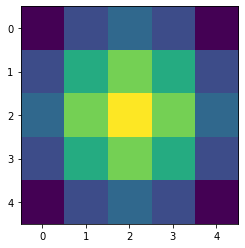

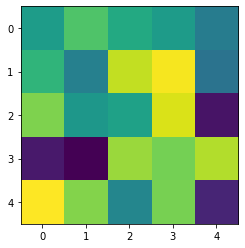

In [3]:
# kernel1
std = 3.0
f = np.vectorize(lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y]))
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
kernel1 = f(X, Y)
kernel1 = kernel1 / kernel1.sum()

# kernel2
np.random.seed(0)
kernel2 = np.random.rand(*kernel1.shape)
kernel2 = kernel2 / kernel2.sum()

plt.imshow(kernel1)
plt.show()

plt.imshow(kernel2)
plt.show()

In [4]:
imgs1 = np.stack([fftconvolve(img, kernel1, mode='same') for img in imgs], axis=0)
imgs2 = np.stack([fftconvolve(img, kernel2, mode='same') for img in imgs], axis=0)

In [5]:
n, nte = 800, 200
x = np.concatenate([imgs1[:n], imgs2[:n]])
y = np.concatenate([np.zeros(n), np.ones(n)])
xte = np.concatenate([imgs1[n:], imgs2[n:]])
yte = np.concatenate([np.zeros(nte), np.ones(nte)])

X = torch.from_numpy(x).to(device).unsqueeze(1).to(torch.float)
Y = torch.from_numpy(y).to(device).unsqueeze(1).to(torch.float)
Xte = torch.from_numpy(xte).to(device).unsqueeze(1).to(torch.float)
Yte = torch.from_numpy(yte).to(device).unsqueeze(1).to(torch.float)

In [6]:
net = MnistNet(m=[5, 5]).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [7]:
batch = 20
for itr in tqdm(range(10000)):
    np.random.seed(itr)
    idx = np.random.choice(2*n, batch)
    Z = net(X[idx])
    loss = loss_fn(Z, Y[idx])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [9]:
Zte = net(Xte)
zte = Zte.detach().to('cpu').numpy()[:, 0]
print(confusion_matrix(yte, zte > 0))

[[196   4]
 [  3 197]]


In [12]:
torch.save(net.state_dict(), 'models/conv.pth')